# Tutorial: Random forest ML project
This tutorial will show you how `mandala` works in a small random forest
ML project. You'll see how **queriable & composable** memoization is a simple way
to achieve the main goals of scientific data management:

- **iterate in the simplest way** by just dumping more
logic/parameters/experiments on top of the code you already ran. Memoization
automatically takes care of loading past results, skipping over past
computations, and merging results across compatible versions of your code.

- **explore the interdependencies of all saved results incrementally and
declaratively** with *computation frames*, generalized dataframes that operate
over memoized computation graphs. Expand the computational history of artifacts
backward (to what produced them) and/or forward (to experiments that used them),
perform high-level operations over slices of storage, and generate dataframes of
results for further analysis.

# Imports & setup

In [1]:
from typing import Tuple
import numpy as np
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# recommended way to import mandala functionality
from mandala._next.imports import *

np.random.seed(0)

In [2]:
@op # memoizing decorator
def generate_dataset(random_seed=42):
    print(f"Generating dataset...")
    X, y = load_digits(return_X_y=True)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=random_seed)
    return X_train, X_test, y_train, y_test

@op
def train_model(X_train, y_train):
    print(f"Training model...")
    model = RandomForestClassifier(n_estimators=1)
    model.fit(X_train, y_train)
    return model, round(model.score(X_train, y_train), 2)

@op
def eval_model(model, X_test, y_test):
    print(f"Evaluating model...")
    return round(model.score(X_test, y_test), 2)

# Running and iterating on the pipeline

## Run the pipeline once with default settings

In [3]:
# in-memory storage for all results in this notebook; use `db_path` to persist
# to disk
storage = Storage() 

with storage: # block to make all @ops called inside read/write to a given storage
    X_train, X_test, y_train, y_test = generate_dataset()
    model, train_acc = train_model(X_train, y_train)
    test_acc = eval_model(model, X_test, y_test)
    print(f"Train accuracy: {train_acc},\nTest accuracy: {test_acc}")

Generating dataset...
Training model...
Evaluating model...
Train accuracy: AtomRef(0.91, hid='8f5...', cid='97b...'),
Test accuracy: AtomRef(0.76, hid='57f...', cid='9e5...')


Now all three calls are saved to the storage. `@op`s return **value 
references**, which wrap a Python object with some storage metadata needed to
make the memoization **compose**. To get the underlying object, call
`storage.unwrap(ref)`.

Thanks to that metadata, when we re-run memoized code, the storage recognizes
step-by-step that all work has already been done, and only loads *references* to
the results (not the Python objects themselves):

In [4]:
with storage: # same code, but now it only loads pointers to saved results
    X_train, X_test, y_train, y_test = generate_dataset()
    model, train_acc = train_model(X_train, y_train)
    test_acc = eval_model(model, X_test, y_test)
    print(f"Train accuracy: {train_acc},\nTest accuracy: {test_acc}")

Train accuracy: AtomRef(hid='8f5...', cid='97b...', in_memory=False),
Test accuracy: AtomRef(hid='57f...', cid='9e5...', in_memory=False)


## Iterate directly on top of memoized code and change memoized functions backward-compatibly
This also makes it easy to iterate on a project by just adding stuff on top of
already memoized code. For example, let's add a new parameter to `train_model`
in a way compatible with our current results:

In [5]:
@op
def train_model(X_train, y_train, n_estimators=NewArgDefault(1)):
    print(f"Training model...")
    model = RandomForestClassifier(n_estimators=n_estimators)
    model.fit(X_train, y_train)
    return model, round(model.score(X_train, y_train), 2)

with storage: 
    X_train, X_test, y_train, y_test = generate_dataset()
    for n_estimators in [1, 10, 100]:
        print(f"Running with {n_estimators} trees...")
        model, train_acc = train_model(X_train, y_train, n_estimators=n_estimators)
        test_acc = eval_model(model, X_test, y_test)
        print(f"    Train accuracy={train_acc},\n    Test accuracy={test_acc}")

Running with 1 trees...
    Train accuracy=AtomRef(hid='8f5...', cid='97b...', in_memory=False),
    Test accuracy=AtomRef(hid='57f...', cid='9e5...', in_memory=False)
Running with 10 trees...
Training model...
Evaluating model...
    Train accuracy=AtomRef(1.0, hid='760...', cid='b67...'),
    Test accuracy=AtomRef(0.94, hid='600...', cid='c3b...')
Running with 100 trees...
Training model...
Evaluating model...
    Train accuracy=AtomRef(1.0, hid='ab0...', cid='b67...'),
    Test accuracy=AtomRef(0.98, hid='45f...', cid='d15...')


When we add a new argument with a default value wrapped as `NewArgDefault(obj)`,
this ensures **backward compatibility**. `mandala` will ignore this parameter
when its value equals `obj`, and **fall back to memoized calls that don't
provide this argument**. 

This is why `Training model...` got printed **only two times**, and why the
results for `n_estimators=1` are not in memory (`in_memory=False`).

## Pros and cons of memoization
**Composable memoization is a powerful imperative query interface**: *if* you
have the memoized code in front of you, **the code becomes its own storage
interface**. You can just retrace it and get references to any intermediate
results you want to look at. This is very flexible, because you can add control
flow logic to restrict the "query". Retracing is cheap, because large objects
are not loaded from storage, letting you narrow down your "query" before
high-bandwidth interaction with the backend.

However, **the full memoized code may not always be in front of you**!
Especially in larger projects, where it's easy to lose track of what has already
been computed, there's a need for a complementary storage interface based on
**declarative** principles. We discuss this next.

# Querying the storage with computation frames 
In cases when memoization-based querying is not enough, `mandala` offers the
`ComputationFrame` class. A computation frame is a generalization of the
familiar `pandas` dataframe in two main ways:

- the "columns" of a computation frame represent a **computational graph**, made
of variables and operations on them.
- the "rows" of a computation frame are **computations that (partially) follow
the structure of the computational graph**.

It's best to illustrate this with some examples:

In [6]:
cf = storage.cf(train_model); cf

ComputationFrame with 5 variable(s) (10 unique refs), 1 operation(s) (3 unique calls)
Computational graph:
    output_0@output_0, output_1@output_1 = train_model(X_train=X_train, y_train=y_train, n_estimators=n_estimators)

We just got a computation frame (CF) corresponding to a very simple computation
graph: it only has one operation, `train_model`, with its associated inputs and
outputs. **Output variables are appended with the name of the function output
they are connected to**, in order to remove ambiguity in cases when not all
outputs of an operation are present in the computational graph.

The printout also describes the overall number of `Ref`s and `Call`s represented
by this CF. Much like in `pandas`, we can rename the "columns" of our
computation frame for readability:

In [7]:
cf.rename(vars={'output_0': 'model', 'output_1': 'train_acc'}, inplace=True); cf

ComputationFrame with 5 variable(s) (10 unique refs), 1 operation(s) (3 unique calls)
Computational graph:
    model@output_0, train_acc@output_1 = train_model(X_train=X_train, y_train=y_train, n_estimators=n_estimators)

We can directly extract a dataframe from the CF:

In [8]:
cf.get_df()

Extracting tuples from the computation graph:
    model@output_0, train_acc@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, X_train=X_train)


,y_train,n_estimators,X_train,train_model,train_acc,model
0,"[6, 0, 0, 3, 0, 5, 0, 0, 4, 1, 2, 8, 4, 5, 9, ...",10.0,"[[0.0, 0.0, 3.0, 14.0, 1.0, 0.0, 0.0, 0.0, 0.0...","Call(train_model, cid='c4f...', hid='5f7...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r..."
1,"[6, 0, 0, 3, 0, 5, 0, 0, 4, 1, 2, 8, 4, 5, 9, ...",100.0,"[[0.0, 0.0, 3.0, 14.0, 1.0, 0.0, 0.0, 0.0, 0.0...","Call(train_model, cid='bb3...', hid='255...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r..."
2,"[6, 0, 0, 3, 0, 5, 0, 0, 4, 1, 2, 8, 4, 5, 9, ...",NaN,"[[0.0, 0.0, 3.0, 14.0, 1.0, 0.0, 0.0, 0.0, 0.0...","Call(train_model, cid='ca5...', hid='ac0...')",0.91,"(DecisionTreeClassifier(max_features='sqrt', r..."


We get back a table, where each row corresponds to a call to `train_model`.
Furthermore, the `Call` objects themselves (which contain metadata about the
call) appear in the column dedicated to the single operation in the graph.

We see that in the `n_estimators` column we have the values `[NaN, 10.0, 100.0]`
(in some order), reflecting the fact that we made 1 call to `train_model` before
introducing the `n_estimators` argument, and 2 afterwards.

## Exploring storage by expanding the CF
This CF gets much more interesting and useful when we can look into where the
inputs to `train_model` came from, and what the outputs were used for. We can
add the history of particular variables by calling `expand_back` on the CF, and 
similarly `expand_forward` shows the operations that consume given variables: 

In [9]:
print('Expanding back the inputs:')
print(cf.expand_back(varnames=["X_train", "y_train"]))
print('\nExpanding forward the outputs:')
print(cf.expand_forward(varnames=['model', 'train_acc']))

Expanding back the inputs:
ComputationFrame with 6 variable(s) (11 unique refs), 2 operation(s) (4 unique calls)
Computational graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    model@output_0, train_acc@output_1 = train_model(X_train=X_train, y_train=y_train, n_estimators=n_estimators)

Expanding forward the outputs:
ComputationFrame with 6 variable(s) (13 unique refs), 2 operation(s) (6 unique calls)
Computational graph:
    model@output_0, train_acc@output_1 = train_model(X_train=X_train, y_train=y_train, n_estimators=n_estimators)
    output_0@output_0 = eval_model(model=model)


We can perform a full expansion (until we can't go back or forward) with the
`.expand()` method:

In [10]:
expanded_cf = cf.expand()
expanded_cf

ComputationFrame with 7 variable(s) (14 unique refs), 3 operation(s) (7 unique calls)
Computational graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    model@output_0, train_acc@output_1 = train_model(X_train=X_train, y_train=y_train, n_estimators=n_estimators)
    output_0@output_0 = eval_model(model=model)

Note that the extracted CF represents a "partial" computation graph: the
variables for `X_test`and `y_test` were not reached during this traversal
(though they can be added). Finally, we can (again) extract a dataframe from
this CF:

In [11]:
expanded_cf.get_df().drop(columns=['X_train', 'y_train']) # drop to avoid a bit of clutter

Extracting tuples from the computation graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    model@output_0, train_acc@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, X_train=X_train)
    output_0@output_0 = eval_model(model=model)


,n_estimators,random_seed,generate_dataset,train_model,train_acc,model,eval_model,output_0
0,10.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....","Call(train_model, cid='c4f...', hid='5f7...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='898...', hid='ed5...')",0.94
1,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....","Call(train_model, cid='ca5...', hid='ac0...')",0.91,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='e1e...', hid='c5a...')",0.76
2,100.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....","Call(train_model, cid='bb3...', hid='255...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='5e5...', hid='07b...')",0.98


## Using computation frames for high-level operations
Finally, we can illustrate the use of computation frames for easy declarative
operations over the storage, even in the presence of highly heterogeneous
experiments. To make this more interesting, let's train some more models:

In [12]:
@op
def train_model(X_train, y_train,
                n_estimators=NewArgDefault(1),
                max_depth=NewArgDefault(None) # one more backward-compatible argument
                ):
    print(f"Training model...")
    model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth)
    model.fit(X_train, y_train)
    return model, round(model.score(X_train, y_train), 2)

with storage: 
    X_train, X_test, y_train, y_test = generate_dataset()
    for n_estimators in [10, 100]:
        for max_depth in [1, 2]:
            model, train_acc = train_model(X_train, y_train, n_estimators=n_estimators, max_depth=max_depth)

Training model...
Training model...
Training model...
Training model...


We left out the call to `eval_model` on purpose to illustrate how CFs handle
heterogeneous and partial computations. 

As before, we build a big CF by expanding backward and forward from
`train_model`, and then extract a dataframe:

In [13]:
cf = storage.cf(train_model).expand().rename(vars={'output_0': 'model', 'output_1': 'train_acc', 'output_0_0': 'eval_acc'})
# use `lazy_vars` to avoid loading the large arrays which we don't need
df = cf.get_df(lazy_vars=['X_train', 'y_train']).drop(columns=['X_train', 'y_train'])
df

Extracting tuples from the computation graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    model@output_0, train_acc@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, max_depth=max_depth, X_train=X_train)
    eval_acc@output_0 = eval_model(model=model)


,max_depth,random_seed,generate_dataset,n_estimators,train_model,train_acc,model,eval_model,eval_acc
0,1.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....",100.0,"Call(train_model, cid='002...', hid='561...')",0.70,"(DecisionTreeClassifier(max_depth=1, max_featu...",None,NaN
1,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",NaN,"Call(train_model, cid='ca5...', hid='ac0...')",0.91,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='e1e...', hid='c5a...')",0.76
2,2.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....",100.0,"Call(train_model, cid='4f4...', hid='fe1...')",0.84,"(DecisionTreeClassifier(max_depth=2, max_featu...",None,NaN
3,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",10.0,"Call(train_model, cid='c4f...', hid='5f7...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='898...', hid='ed5...')",0.94
4,2.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....",10.0,"Call(train_model, cid='872...', hid='e61...')",0.71,"(DecisionTreeClassifier(max_depth=2, max_featu...",None,NaN
5,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",100.0,"Call(train_model, cid='bb3...', hid='255...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='5e5...', hid='07b...')",0.98
6,1.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....",10.0,"Call(train_model, cid='22f...', hid='f56...')",0.59,"(DecisionTreeClassifier(max_depth=1, max_featu...",None,NaN


We see that the various missing computational paths show up as `NaN`s in the 
table, under either variables (e.g. `max_depth`) or operations (e.g.
`eval_model`). 

Suppose we want the models where train accuracy was above 0.8 and max depth was 2. 
We can do this with familiar dataframe operations:

In [14]:
df.query('train_acc > 0.8 and max_depth == 2').model.tolist()

[RandomForestClassifier(max_depth=2)]

Similarly, we can manipulate storage by e.g. deleting calls based on this
dataframe. For example, we can delete all calls to `train_model` where 
`train_acc < 0.8`:

In [28]:
storage.drop_calls(df.query('train_acc < 0.8').train_model, delete_dependents=True)
# now check that the dropped calls are gone
cf = storage.cf(train_model).expand().rename(vars={'output_0': 'model', 'output_1': 'train_acc', 'output_0_0': 'eval_acc'})
cf.get_df(lazy_vars=['X_train', 'y_train']).drop(columns=['X_train', 'y_train'])

[00:08:04] INFO     Dropped 0 calls (and 0 from cache).                                              storage.py:346

Extracting tuples from the computation graph:
    X_train@output_0, y_train@output_2 = generate_dataset(random_seed=random_seed)
    model@output_0, train_acc@output_1 = train_model(y_train=y_train, n_estimators=n_estimators, max_depth=max_depth, X_train=X_train)
    eval_acc@output_0 = eval_model(model=model)


,max_depth,random_seed,generate_dataset,n_estimators,train_model,train_acc,model,eval_model,eval_acc
0,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",10.0,"Call(train_model, cid='c4f...', hid='5f7...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='898...', hid='ed5...')",0.94
1,2.0,42,"Call(generate_dataset, cid='19a...', hid='c3f....",100.0,"Call(train_model, cid='4f4...', hid='fe1...')",0.84,"(DecisionTreeClassifier(max_depth=2, max_featu...",None,NaN
2,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",100.0,"Call(train_model, cid='bb3...', hid='255...')",1.00,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='5e5...', hid='07b...')",0.98
3,NaN,42,"Call(generate_dataset, cid='19a...', hid='c3f....",NaN,"Call(train_model, cid='ca5...', hid='ac0...')",0.91,"(DecisionTreeClassifier(max_features='sqrt', r...","Call(eval_model, cid='e1e...', hid='c5a...')",0.76



    digraph G {
        graph [ overlap="scale",rankdir="TB",fontname="RobotoMono",fontsize="10",fontcolor="#002b36ff" ];
            node [ style="rounded",shape="rect",fontname="RobotoMono",fontsize="10",fontcolor="#002b36ff" ];
            edge [ fontname="RobotoMono",fontsize="10",fontcolor="#002b36ff" ];
        "X_train" [label=<<B><FONT POINT-SIZE="12">X_train</FONT></B><BR/><FONT color="#268bd2ff" point-size="10">1 refs</FONT><BR/>>, color="#268bd2ff", shape="rect"];
            "model" [label=<<B><FONT POINT-SIZE="12">model</FONT></B><BR/><FONT color="#268bd2ff" point-size="10">4 refs</FONT><BR/><FONT color="#002b36ff" point-size="10">1 sink refs</FONT><BR/>>, color="#268bd2ff", shape="rect"];
            "n_estimators" [label=<<B><FONT POINT-SIZE="12">n_estimators</FONT></B><BR/><FONT color="#268bd2ff" point-size="10">2 refs</FONT><BR/><FONT color="#002b36ff" point-size="10">2 source refs</FONT><BR/>>, color="#268bd2ff", shape="rect"];
            "y_train" [label=<<B><FONT 

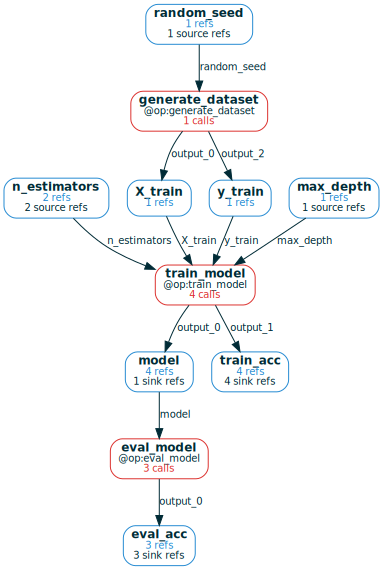

In [29]:
cf.draw(verbose=True, orientation='TB')